# Sentence Reconstruction

The purpose of this project is to take in input a sequence of words corresponding to a random permutation of a given english sentence, and reconstruct the original sentence.

The otuput can be either produced in a single shot, or through an iterative (autoregressive) loop generating a single token at a time.


CONSTRAINTS:
* No pretrained model can be used.
* The neural network models should have less the 20M parameters.
* No postprocessing should be done (e.g. no beamsearch)
* You cannot use additional training data.


BONUS PARAMETERS:

A bonus of 0-2 points will be attributed to incentivate the adoption of models with a low number of parameters.

# Dataset preprocessing

The dataset is composed by sentences taken from the generics_kb dataset of hugging face. We restricted the vocabolary to the 10K most frequent words, and only took sentences making use of this vocabulary.

If dataset.pkl and tokenizer_config.pkl are already prepared, set DUMP_ENABLE to True, otherwise to False.

In [ ]:
DUMP_ENABLE = True

### Importing Dataset and Tokenizer config from pkl files (DUMP_ENABLE = True)

In [ ]:
from keras.layers import TextVectorization
import tensorflow as tf
import numpy as np
import pickle

In [ ]:
class TextDetokenizer:
    def __init__(self, vectorize_layer):
        self.vectorize_layer = vectorize_layer
        vocab = self.vectorize_layer.get_vocabulary()
        self.index_to_word = {index: word for index, word in enumerate(vocab)}

    def __detokenize_tokens(self, tokens):
        def check_token(t):
          if t == 3:
            s="<start>"
          elif t == 2:
            s="<end>"
          elif t == 7:
            s="<comma>"
          else:
            s=self.index_to_word.get(t, '[UNK]')
          return s

        return ' '.join([ check_token(token) for token in tokens if token != 0])

    def __call__(self, batch_tokens):
       return [self.__detokenize_tokens(tokens) for tokens in batch_tokens]

## Read Tokenizer object configuration from pkl file
with open('./Resources/tokenizer_config.pkl', mode='rb') as f:
  file_data = pickle.load(f) 
  tokenizer = TextVectorization.from_config(file_data['config'])
  tokenizer.set_weights(file_data['weights'])

detokenizer = TextDetokenizer( tokenizer )

Reading tokenized version of the original dataset from the pkl file.

In [ ]:
with open('./Resources/dataset.pkl', mode='rb') as f:
  file_data = pickle.load(f) 
  original_data = file_data['dataset']

### Downloading Dataset and building Tokenizer from scratch (DUMP_ENABLE = False)

In [1]:
!pip install datasets

Download the dataset

In [2]:
from datasets import load_dataset
from keras.layers import TextVectorization
import tensorflow as tf
import numpy as np
import pickle
np.random.seed(42)
ds = load_dataset('generics_kb',trust_remote_code=True)['train']

Filter row with length greater than 8.


In [3]:
ds = ds.filter(lambda row: len(row["generic_sentence"].split(" ")) > 8 )
corpus = [ '<start> ' + row['generic_sentence'].replace(","," <comma>") + ' <end>' for row in ds ]
corpus = np.array(corpus)


Create a tokenizer and Detokenizer

In [4]:
tokenizer=TextVectorization( max_tokens=10000, standardize="lower_and_strip_punctuation", encoding="utf-8",) #con il max prende le piu frequenti. ordina i token del vocab dal piu frequente al meno frequente
tokenizer.adapt(corpus)

## Write configuration file for Tokenizer object (NOT NEEDED if already present)
with open('./Resources/tokenizer_config.pkl', mode='wb') as f:
    pickle.dump({'config': tokenizer.get_config(), 'weights': tokenizer.get_weights()}, f)

class TextDetokenizer:
    def __init__(self, vectorize_layer):
        self.vectorize_layer = vectorize_layer
        vocab = self.vectorize_layer.get_vocabulary()
        self.index_to_word = {index: word for index, word in enumerate(vocab)}

    def __detokenize_tokens(self, tokens):
        def check_token(t):
          if t == 3:
            s="<start>"
          elif t == 2:
            s="<end>"
          elif t == 7:
            s="<comma>"
          else:
            s=self.index_to_word.get(t, '[UNK]')
          return s

        return ' '.join([ check_token(token) for token in tokens if token != 0])

    def __call__(self, batch_tokens):
       return [self.__detokenize_tokens(tokens) for tokens in batch_tokens]


detokenizer = TextDetokenizer( tokenizer )
sentences = tokenizer( corpus ).numpy()

2024-06-11 23:22:04.161688: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-11 23:22:04.161946: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-11 23:22:04.162102: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Remove from corpus the sentences where any unknow word appears

In [5]:
mask = np.sum( (sentences==1), axis=1) >= 1
original_data = np.delete( sentences, mask , axis=0)

In [6]:
original_data.shape

(241236, 28)

Store tokenized version of the original dataset in order to speed up process for further implementations and modifications.

(NOT NEEDED if file is already present)

In [ ]:
with open('./Resources/dataset.pkl', mode='wb') as f:
    pickle.dump({'dataset': original_data}, f)

### DataGenerator object

Data  -> sequence of shuffled sentences.

Label -> sequence of ordered sentences.

DataGenerator object adjusted in order to return:
- tuple of 2 elements:
    - data_batch: matrix of dim (batch_size, max_token_length) (64, 28), tokenized data.
    - label_batch: matrix of dim (batch_size, max_token_length) (64, 28), tokenized label.
- label_batch_enc: matrix of dim (batch_size, max_token_length, vocab_size) (64, 28, 10000), tokenized label one-hot encoded in respect of position of each token in vocabulary.  

In [7]:
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, data, batch_size, vocab_size, shuffle=True, seed=42):
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.seed = seed
        self.vocab_size = vocab_size
        self.on_epoch_end()


    def __len__(self):
        return int(np.floor(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        data_batch = np.array([self.data[k] for k in indexes])
        #copy of ordered sequences
        result = np.copy(data_batch)
        #shuffle only the relevant positions for each batch
        for i in range(data_batch.shape[0]):
          np.random.shuffle(data_batch[i,1:data_batch[i].argmin() - 1])

        return self.onehot_encode_ds(data_batch, result, data_batch.shape[0], 28, self.vocab_size)

    def onehot_encode_ds(self, data_batch, label_batch, batch_size, max_length, vocab_size):

        ## Creating Label matrix where each token is One-Hot encoded (without <start> encoded token)
        zeros_arr = np.zeros(shape=(batch_size, max_length, vocab_size), dtype=np.int64)
        for i in range(batch_size): # Batch size
            for el in range(1, max_length):
                tf_arr_col = np.zeros(shape=(vocab_size, ), dtype=np.int64)

                if label_batch[i, el] != 0:
                    tf_arr_col[label_batch[i, el]] = 1

                zeros_arr[i, el-1, :] = tf_arr_col

        ## Creating Label matrix (without <end> token)
        for i in range(batch_size): # Batch size
            is_end_pos = np.where(label_batch[i, :] == 2)[0][0] # <end> token encoded as 2
            label_batch[i, is_end_pos] = 0

        return (data_batch, label_batch), zeros_arr

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.shuffle:
            if self.seed is not None:
                np.random.seed(self.seed)
            np.random.shuffle(self.indexes)

In [8]:
# Make a random permutation of training and test set
np.random.seed(42)
# Shuffle the all data
shuffled_indices = np.random.permutation(len(original_data))
shuffled_data = original_data[shuffled_indices]

Splitting dataset into 3 generators.

len(Train + Validation) = 220000

len(Train) = 90% * len(Train + Validation) = 198000

In [9]:
tot_size = len(shuffled_data) # 241236
train_val_size = 220000
train_size = int(0.9 * train_val_size)

print(f'Effective Train size: {train_size}')


Effective Train size: 198000


In [10]:
train_generator = DataGenerator(shuffled_data[:train_size], batch_size=128, vocab_size=tokenizer.vocabulary_size())
val_generator = DataGenerator(shuffled_data[train_size:train_val_size], batch_size=128, vocab_size=tokenizer.vocabulary_size())
test_generator = DataGenerator(shuffled_data[train_val_size:], batch_size=128, vocab_size=tokenizer.vocabulary_size())

In [11]:
print(f'Number of batches in Train generator: {len(train_generator)}')
print(f'Number of batches in Test generator: {len(test_generator)}')
print(f'Number of batches in Validation generator: {len(val_generator)}')

Number of batches in Train generator: 1546
Number of batches in Test generator: 165
Number of batches in Validation generator: 171


#### Checking pre-processing

Extracting example of train batch.

In [12]:
x, y = train_generator.__getitem__(1)

print(x[0].shape)
print(x[1].shape)
print(y.shape)

(128, 28)
(128, 28)
(128, 28, 10000)


Printing tokenized Data, shuffled and label.

NB: < end > token is not present in label.

In [13]:
## Tokenized data
for i in range(1):
  print("shuffled: ", x[0][i])
  print("label: ", x[1][i])
  print("\n")

shuffled:  [   3   27 7177   36    5 5630   87    4 2731    7   22    8   11 1828
 1626    4    2    0    0    0    0    0    0    0    0    0    0    0]
label:  [   3 5630    8   36    5    4   22 1626 1828   11    4   87    7 7177
   27 2731    0    0    0    0    0    0    0    0    0    0    0    0]




Check of position of the assigned 1 in the One-Hot encoded version of the label. 

NB: the label is shifted right, < start > token is not present.

In [14]:
for i in range(1):
  for el in range(28):
    print(np.where(y[i, el, :]==1)[0])

[5630]
[8]
[36]
[5]
[4]
[22]
[1626]
[1828]
[11]
[4]
[87]
[7]
[7177]
[27]
[2731]
[2]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


Checking if the detokenizer is working as expected.

In [15]:
## Detokenized data
x_dec = detokenizer(x[0])
y_dec = detokenizer(x[1])

for i in range(7):
  print("original: ", y_dec[i])
  print("shuffled: ", x_dec[i])
  print("\n")

original:  <start> aviation is one of the most dynamic industries in the world <comma> offering many opportunities
shuffled:  <start> many offering one of aviation world the opportunities <comma> most is in industries dynamic the <end>


original:  <start> peat deposition is the first step in the formation of coal
shuffled:  <start> formation the coal of step the deposition peat is in first <end>


original:  <start> brown snakes cause more deaths in australia than any other snake
shuffled:  <start> australia in brown snakes other any more than snake cause deaths <end>


original:  <start> sexual assault happens most often between people who know each other
shuffled:  <start> people assault know each happens often other sexual most who between <end>


original:  <start> parasitism is the type of relationship the guinea worms are
shuffled:  <start> guinea the worms of are parasitism is the relationship type <end>


original:  <start> depreciation is defined as a loss in value due to any

# Metrics

Let s be the source string and p your prediction. The quality of the results will be measured according to the following metric:

1.  look for the longest substring w between s and p
2.  compute |w|/max(|s|,|p|)

If the match is exact, the score is 1.

When computing the score, you should NOT consider the start and end tokens.



The longest common substring can be computed with the SequenceMatcher function of difflib, that allows a simple definition of our metric.

In [16]:
from difflib import SequenceMatcher

def score(s,p):
  match = SequenceMatcher(None, s, p).find_longest_match()
  #print(match.size)
  return (match.size/max(len(p),len(s)))

Let's do an example.

In [17]:
original = "at first henry wanted to be friends with the king of france"
generated = "henry wanted to be friends with king of france at the first"

print("your score is ",score(original,generated))

your score is  0.5423728813559322


The score must be computed as an average of at least 3K random examples taken form the test set.

# What to deliver

You are supposed to deliver a single notebook, suitably commented.
The notebook should describe a single model, although you may briefly discuss additional attempts you did.

The notebook should contain a full trace of the training.
Weights should be made available on request.

You must also give a clear assesment of the performance of the model, computed with the metric that has been given to you.

# Good work!

## Neural Network Architecture

The project takes ispiration from the implementation of the Transformer structure present on https://www.tensorflow.org/text/tutorials/transformer (Tensorflow documentation), also based on the Transfomer original paper "Attention Is All You Need".

Moreover, I also tried integrating the standard structure with a new one based on a reaserch, called "On Layer Normalization in the Transformer Architecture" by Ruibin Xiong, Yunchang Yang, Di He, Kai Zheng, Shuxin Zheng, Chen Xing, Huishuai Zhang, Yanyan Lan, Liwei Wang, Tie-Yan Liu (https://arxiv.org/abs/2002.04745).

This reaserch demonstrated that positioning the Layer Normalization in front of the Multi-Head Attention layer could bring improvements in terms of performances, as they showed that the new structure could be able to reach comparable results to the ones with standard Transformer requiring less training time.

I specify this only to motivate the chosen structure of the Transformer.

### Embedding Block

Identical for both the encoder and decoder stack.

In [19]:
class Embedding_fromScratch(tf.keras.layers.Layer):
  def __init__(self, vocab_size, dim_embedding, max_token_length):
    super().__init__()

    self.vocab_size = vocab_size
    self.dim_embedding = dim_embedding
    self.max_token_length = max_token_length
    
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, self.dim_embedding, mask_zero=True)
    self.pos_embedding = tf.keras.layers.Embedding(self.max_token_length, self.dim_embedding)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    # Token Embedding
    x = self.embedding(x)
    
    # Psitional Encoding
    y = self.pos_embedding(np.arange(0, self.max_token_length, 1))

    x += y
    return x

### Encoder

#### Single Encoder layer

In [20]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, num_heads, d_model, dff, dim_embedding):
        super().__init__()

        self.lay_norm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.multi_h_att1 = tf.keras.layers.MultiHeadAttention(num_heads=num_heads,
                                                               key_dim=d_model)
        self.dropout1 = tf.keras.layers.Dropout(rate=0.1)

        self.lay_norm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.lin_layer1 = tf.keras.layers.Dense(dff, activation='relu')
        self.lin_layer2 = tf.keras.layers.Dense(dim_embedding)
        self.dropout2 = tf.keras.layers.Dropout(rate=0.1)
        
        self.lay_norm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)


    def call(self, x):

        init_input = x

        # Layer Normalization
        x = self.lay_norm1(x)

        # Multi Head Attention layer
        x = self.multi_h_att1(
            query=x,
            key=x,
            value=x
        )
        x = self.dropout1(x)

        # Add layer
        x += init_input

        ## Dense layer (idkw)
        init_input2 = x

        # Layer Normalization
        x = self.lay_norm2(x)

        # Feed-Forward block
        x = self.lin_layer1(x)
        x = self.lin_layer2(x)
        x = self.dropout2(x)

        # Add layer
        x += init_input2

        # Last Layer Normalization
        x = self.lay_norm3(x)
        return x

#### Encoder stack

In [21]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_heads, d_model, num_enc_layers,
                 vocab_size, dim_embedding, max_token_length, dff):
        super().__init__()

        self.embedding = Embedding_fromScratch(vocab_size, dim_embedding, max_token_length)

        self.dropout = tf.keras.layers.Dropout(rate=0.1)

        self.num_layers = num_enc_layers
        self.enc_layers = [
            EncoderLayer(num_heads=num_heads, d_model=d_model, dff=dff, dim_embedding=dim_embedding) for i in range(num_enc_layers)
        ]

    def call(self, x):

        ## Embedding block (Token Embedding + Positional Encoding)
        x = self.embedding(x)

        x = self.dropout(x)

        ## Num_layers stack of Encoder layers
        for i in range(self.num_layers):
            x = self.enc_layers[i](x)

        return x


### Decoder

#### Single Decoder layer

In [22]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, num_heads, d_model, dff, dim_embedding):
        super().__init__()

        self.lay_norm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.multi_h_att1 = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.dropout1 = tf.keras.layers.Dropout(rate=0.1)

        self.lay_norm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.multi_h_att2 = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.dropout2 = tf.keras.layers.Dropout(rate=0.1)

        self.lay_norm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.lin_layer1 = tf.keras.layers.Dense(dff, activation='relu')
        self.lin_layer2 = tf.keras.layers.Dense(dim_embedding)
        self.dropout3 = tf.keras.layers.Dropout(rate=0.1)
        self.lay_norm4 = tf.keras.layers.LayerNormalization(epsilon=1e-6)


    def call(self, x, encoded_input):

        init_input1 = x

        # Layer Normalization
        x = self.lay_norm1(x)

        # Multi Head Attention layer
        x = self.multi_h_att1(
            query=x,
            key=x,
            value=x,
            use_causal_mask=True
        )
        x = self.dropout1(x)

        # Add and Norm layer
        x += init_input1

        init_input2 = x

        # Layer Normalization
        x = self.lay_norm2(x)

        # Multi Head Attention layer considering both output and input_encoded
        x = self.multi_h_att2(
           query=x,
           key=encoded_input,
           value=encoded_input
        )
        x = self.dropout2(x)

        # Add and Norm layer
        x += init_input2

        ## Dense layer (idkw)
        init_input3 = x

        # Layer Normalization
        x = self.lay_norm3(x)

        # Last Feed-Forward block
        x = self.lin_layer1(x)
        x = self.lin_layer2(x)
        x = self.dropout2(x)

        # Add and Norm layer
        x += init_input3

        # Last Layer Normalization
        x = self.lay_norm4(x)
        
        return x

#### Decoder stack

In [23]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_heads, d_model, num_dec_layers,
                 vocab_size, dim_embedding, max_token_length, dff):
        super().__init__()

        self.embedding = Embedding_fromScratch(vocab_size, dim_embedding, max_token_length)

        self.dropout = tf.keras.layers.Dropout(rate=0.1)

        self.num_layers = num_dec_layers
        self.dec_layers = [
            DecoderLayer(num_heads=num_heads, d_model=d_model, dff=dff, dim_embedding=dim_embedding) for i in range(num_dec_layers)
        ]

    def call(self, x, encoded_input):

        ## Embedding block (Token Embedding + Positional Encoding)
        x = self.embedding(x)

        x = self.dropout(x)

        ## Num_layers stack of Decoder layers
        for i in range(self.num_layers):
            x = self.dec_layers[i](x, encoded_input)

        return x

### Entire Transformer

In [24]:
class Reorder_Transformer(tf.keras.Model):
    def __init__(self,
                 num_heads, d_model,
                 num_enc_layers,
                 num_dec_layers,
                 vocab_size, dim_embedding, max_token_length,
                 dff
                 ):
        super().__init__()

        self.encoder = Encoder(num_heads=num_heads,
                               d_model=d_model,
                               num_enc_layers=num_enc_layers,
                               vocab_size=vocab_size,
                               dim_embedding=dim_embedding,
                               max_token_length=max_token_length,
                               dff=dff)

        self.decoder = Decoder(num_heads=num_heads,
                               d_model=d_model,
                               num_dec_layers=num_dec_layers,
                               vocab_size=vocab_size,
                               dim_embedding=dim_embedding,
                               max_token_length=max_token_length,
                               dff=dff)

        self.lin_layer1 = tf.keras.layers.Dense(dff, activation='relu')
        self.lin_layer2 = tf.keras.layers.Dense(vocab_size, activation='softmax')

    def call(self, input):
        # Extracting shuffled data sentences and their label (as sequence of tokens)
        x, y = input

        # Encoder: takes as input shuffled data sentences
        x = self.encoder(x)

        # Encoder: takes as input: label and Encoder output
        z = self.decoder(y, x)

        # Final linear layers classifier
        z = self.lin_layer1(z)
        z = self.lin_layer2(z)
        
        return z

## Compilation of the model

Hyperparameter configuration:

- num_heads = 6, (number of attention heads used for each Multi-Attention layer)
- d_model = 128, (used as key dimensionality foe each Multi-Attention layer)
- num_enc_layers = 4, (number of Encoder's layer)
- num_dec_layers = 4, (number of Decoder's layer)
- vocab_size = 10000, (vocabulary dimension used as output size for last Softmax)
- dim_embedding = 128, (dimesion of the Token Embedding)
- max_token_length = 28, (used as maximum reference for the length of shuffled sentences)
- dff = 512, (Feed-Forward block's number of neurons)


In [39]:
# Warm-up steps 2000 - steps_per_epoch 500 validation_steps 100 - Score 0.47 - my_weights3.h5
max_input_dim = 28
vocabulary_dim = len(tokenizer.get_vocabulary())

reorder_model = Reorder_Transformer(num_heads=6, d_model=128,
                                    num_enc_layers=4, num_dec_layers=4,
                                    vocab_size=vocabulary_dim, dim_embedding=128,
                                    max_token_length=max_input_dim,
                                    dff=512)

In [40]:
def masked_loss(label, pred):
  # Computation of loss function as simple Categorical Cross Entropy
  loss_object = tf.keras.losses.CategoricalCrossentropy(
    from_logits=False, reduction='none')
  loss = loss_object(label, pred)

  # Reducing Label dimension summing over the third axis (vocabulary size = 10000)
  label_red = tf.reduce_sum(label, axis=2)

  # Creating boolean mask for being able to detect zero-padding
  mask = label_red != 0
  mask = tf.cast(mask, dtype=tf.float32)
  mask = tf.cast(mask, dtype=loss.dtype)

  # Applying mask
  loss *= mask

  # Averaging loss in reaspect of the dimension of the just applied mask 
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


Learning rate schedules tried:

*   Custom Schedule (with 2000 warmup steps)



In [43]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=2000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


In [44]:
# Learning rate scheduler based on CustomSchedule object: (d_model**-0.5) * min(step**-0.5, step * (warmup_steps**-1.5))
lr_scheduled = CustomSchedule(128) # key_dim or d_model

optimizer = tf.keras.optimizers.Adam(lr_scheduled)

Callback functions:


*   EarlyStopping based on val_categorical_accuracy



In [45]:
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_categorical_accuracy', mode = 'max', patience = 5, restore_best_weights = True)

In [46]:
reorder_model.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=['categorical_accuracy'])

#### Checking model structure

In [47]:
x, y = train_generator.__getitem__(1)

pred = reorder_model(x)

print(f'output shape: {pred.shape}')

output shape: (128, 28, 10000)


In [48]:
reorder_model.summary()

Model: "reorder__transformer_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  3396096   
                                                                 
 decoder_1 (Decoder)         multiple                  4979712   
                                                                 
 dense_34 (Dense)            multiple                  66048     
                                                                 
 dense_35 (Dense)            multiple                  5130000   
                                                                 
Total params: 13571856 (51.77 MB)
Trainable params: 13571856 (51.77 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Training model

If weights file is already present, it can be loaded to the model.

In [ ]:
reorder_model.load_weights('./Resources/my_weights3.h5')

Hyperparameters for fitting model:

- loss = masked Categorical Cross Entropy,
- optimizer = Adam, (following CustomSchedule learning rate)
- metrics = categorical accuracy, (not the most precise, but quite good at bringing information of training trend)
- train_size = 198000,
- epochs = 30,
- steps_per_epochs = 500,
- validation_size = 22000,
- validation_steps = 100,
- callback = EarlyStopping, (monitoring if val_categorical_accuracy stop increasing for more than 5 epochs)

In [50]:
history = reorder_model.fit(train_generator, epochs=30, steps_per_epoch=500, validation_data=val_generator, validation_steps=100, callbacks = [callback])

Epoch 1/30
500/500 [==============================] - 223s 446ms/step - loss: 4.7947 - categorical_accuracy: 0.1558 - val_loss: 4.0055 - val_categorical_accuracy: 0.1924
Epoch 2/30
500/500 [==============================] - 225s 449ms/step - loss: 3.5090 - categorical_accuracy: 0.2179 - val_loss: 2.9254 - val_categorical_accuracy: 0.2585
Epoch 3/30
500/500 [==============================] - 227s 454ms/step - loss: 2.6623 - categorical_accuracy: 0.2643 - val_loss: 2.3106 - val_categorical_accuracy: 0.2889
Epoch 4/30
500/500 [==============================] - 228s 456ms/step - loss: 2.1831 - categorical_accuracy: 0.2895 - val_loss: 2.0126 - val_categorical_accuracy: 0.3067
Epoch 5/30
500/500 [==============================] - 229s 458ms/step - loss: 1.7885 - categorical_accuracy: 0.3122 - val_loss: 1.6551 - val_categorical_accuracy: 0.3282
Epoch 6/30
500/500 [==============================] - 229s 457ms/step - loss: 1.5245 - categorical_accuracy: 0.3289 - val_loss: 1.4525 - val_categoric

### Plotting history

In [51]:
import matplotlib.pyplot as plt

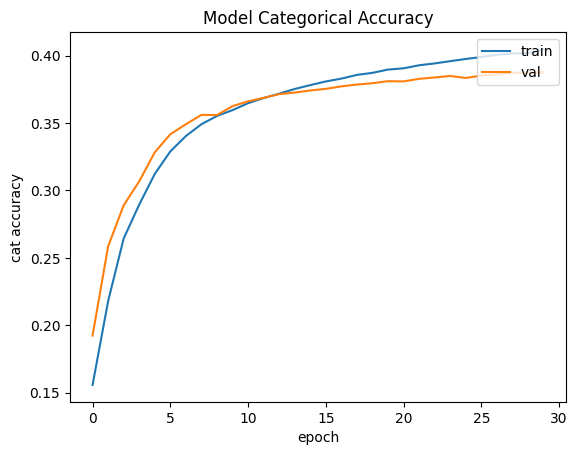

In [52]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model Categorical Accuracy')
plt.ylabel('cat accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

Loss function is decreasing for both the train set and validation one.

Surely more epochs would bring improvements, I couldn't try it only for time reasons.

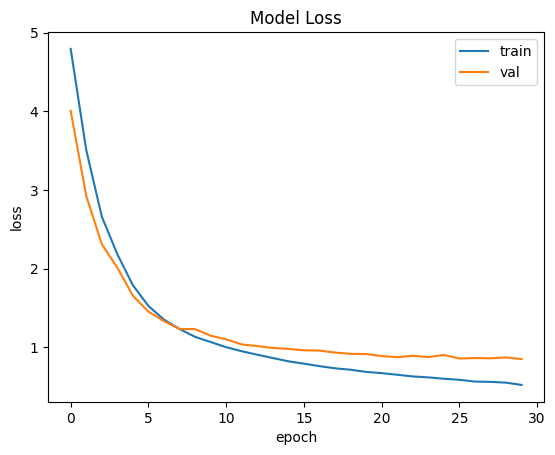

In [53]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

### Saving weights of current model

In [54]:
reorder_model.save_weights('./Resources/my_weights3.h5')

## Scoring evaluation

Scores evaluation based on comparison of random shuffled sentences and ordered ones.

Threshold computed as sum of average of random_scores and 3 times its standard deviation.

In [55]:
from tqdm import tqdm

random_scores = []
for (data, label), _ in tqdm(test_generator):
    str_data = detokenizer( data )
    str_y = detokenizer( label )

    for j in range(64):
        random_scores.append(score(str_y[j][8:].strip(), str_data[j][8:-5].strip())) # masking <start> and <end> token in sentences

print(f'Media random scores: {np.mean(random_scores)}')
print(f'Std random scores: {np.std(random_scores)}')
print(f'Threshold random scores: {np.mean(random_scores) + 3*np.std(random_scores)}')

100%|██████████| 165/165 [00:26<00:00,  6.31it/s]

Media random scores: 0.19127912323845322
Std random scores: 0.05624430524788721
Threshold random scores: 0.36001203898211487


Scoring evaluation on test_generator between prediction of the shuffled sentences and ordered ones.

In [56]:
from tqdm import tqdm

scores = []

for (x, label), _ in tqdm(test_generator):

  # Initializing tokenized sentence to put as input of the Decoder
  res = [3] + [0] * 27
  res = np.array([res for _ in range(x.shape[0])])

  str_y = detokenizer( label )


  # Initializing Boolean vector, element True if found <end> token in batch element (sentence)
  is_finished = [ False for _ in range(64) ]

  for i in range(27):
    out = reorder_model.predict_on_batch(( x, res ))

    for j in range(64):
      if is_finished[j]: # if already found <end> token in batch element continue, skip iteration
        continue
      
      # Appending best token predicted by the model as new element of the sentence provided as Decoder input  
      res[j, i+1] = np.argmax(out[j, i, :])

      if res[j, i+1] == 2: # <end> token encoded as 2
        str_res = detokenizer([res[j, :]])
        scores.append(score(str_y[j][8:].strip(), str_res[0][8:-5].strip())) # masking <start> and <end> token in sentences
        is_finished[j] = True # <end> token found

print(f'\nPrinting definitive average of score: {np.mean(scores)}')

100%|██████████| 165/165 [13:52<00:00,  5.04s/it]


Printing definitive average of score: 0.4718849624528421
